# Metric Score Diff Checker

This notebook provides utilities to compare scores between different metric versions, algorithms, LLMs, or datasets.

## Dataset
This notebook uses the amnesty_qa dataset which contains human rights related Q&A pairs. It will attempt to load from HuggingFace and fallback to local samples if unavailable.

In [19]:
import asyncio
import time
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd

# Ragas imports
from ragas.dataset_schema import SingleTurnSample

## Setup

Make sure you have your OpenAI API key set as an environment variable before running this notebook.

In [20]:
import os
import sys
from pathlib import Path

# Add tests directory to path so we can import from tests.utils
tests_dir = Path.cwd().parent.parent
sys.path.insert(0, str(tests_dir))

from tests.utils import check_api_key

# Check for OpenAI API key
try:
    check_api_key("openai")
    print("✓ OpenAI API key found")
except ValueError as e:
    raise ValueError(str(e))

✓ OpenAI API key found


## Utility Functions

In [21]:
@dataclass
class MetricDiffResult:
    """Container for metric comparison results."""

    old_scores: List[float]
    new_scores: List[float]
    diffs: List[float]
    mean_diff: float
    max_diff: float
    min_diff: float
    std_diff: float
    old_mean: float
    new_mean: float
    old_time: float
    new_time: float

    def to_dataframe(self) -> pd.DataFrame:
        """Convert results to a pandas DataFrame."""
        return pd.DataFrame(
            {
                "old_score": self.old_scores,
                "new_score": self.new_scores,
                "diff": self.diffs,
                "abs_diff": [abs(d) for d in self.diffs],
            }
        )

    def print_summary(self):
        """Print a summary of the comparison."""
        print("=" * 60)
        print("METRIC COMPARISON SUMMARY")
        print("=" * 60)
        print("\nScore Statistics:")
        print(f"  Old Metric Mean: {self.old_mean:.4f}")
        print(f"  New Metric Mean: {self.new_mean:.4f}")
        print("\nDifference Statistics (new - old):")
        print(f"  Mean Diff:   {self.mean_diff:.4f}")
        print(f"  Max Diff:    {self.max_diff:.4f}")
        print(f"  Min Diff:    {self.min_diff:.4f}")
        print(f"  Std Dev:     {self.std_diff:.4f}")
        print("\nExecution Time:")
        print(f"  Old Metric:  {self.old_time:.2f}s")
        print(f"  New Metric:  {self.new_time:.2f}s")
        print(
            f"  Speedup:     {self.old_time / self.new_time:.2f}x"
            if self.new_time > 0
            else "  N/A"
        )
        print("=" * 60)

In [22]:
async def run_metric_on_dataset(
    metric: Any,
    dataset: List[Dict[str, Any]],
    metric_type: str = "old",
    max_concurrent: int = 10,
) -> Tuple[List[float], float]:
    """
    Run a metric on a dataset with concurrent processing for better performance.

    Args:
        metric: The metric instance (either old or new style)
        dataset: List of dictionaries containing the data samples
        metric_type: "old" for legacy metrics, "new" for collections metrics
        max_concurrent: Maximum number of concurrent requests (default: 10)

    Returns:
        Tuple of (scores list, execution time in seconds)
    """

    async def score_single_sample(sample_dict: Dict[str, Any]) -> float:
        """Score a single sample."""
        try:
            if metric_type == "old":
                # Old metrics use SingleTurnSample
                sample = SingleTurnSample(**sample_dict)
                score = await metric._single_turn_ascore(sample, callbacks=None)
            else:
                # New metrics use direct kwargs
                result = await metric.ascore(**sample_dict)
                score = result.value

            return float(score)
        except Exception as e:
            print(f"Error processing sample: {e}")
            return np.nan

    start_time = time.time()

    # Use semaphore to limit concurrent requests (prevents API rate limiting)
    semaphore = asyncio.Semaphore(max_concurrent)

    async def score_with_limit(sample_dict: Dict[str, Any]) -> float:
        """Score with concurrency control."""
        async with semaphore:
            return await score_single_sample(sample_dict)

    # Process all samples concurrently
    scores = await asyncio.gather(*[score_with_limit(s) for s in dataset])

    execution_time = time.time() - start_time
    return list(scores), execution_time

In [23]:
async def compare_metrics(
    old_metric: Any,
    new_metric: Any,
    dataset: List[Dict[str, Any]],
    old_metric_type: str = "old",
    new_metric_type: str = "new",
    max_concurrent: int = 10,
    parallel_metrics: bool = True,
) -> MetricDiffResult:
    """
    Compare two metrics on the same dataset with optional parallel execution.

    Args:
        old_metric: The baseline/old metric instance
        new_metric: The new/updated metric instance
        dataset: List of dictionaries containing the data samples
        old_metric_type: Type identifier for old metric ("old" or "new")
        new_metric_type: Type identifier for new metric ("old" or "new")
        max_concurrent: Maximum number of concurrent requests per metric (default: 10)
        parallel_metrics: If True, run both metrics in parallel. If False, run sequentially
                         for more accurate individual timing (default: True)

    Returns:
        MetricDiffResult containing comparison statistics
    """
    if parallel_metrics:
        print(f"Running both metrics in parallel on {len(dataset)} samples (max {max_concurrent} concurrent)...")
        
        # Run both metrics concurrently using asyncio.gather
        (old_scores, old_time), (new_scores, new_time) = await asyncio.gather(
            run_metric_on_dataset(old_metric, dataset, old_metric_type, max_concurrent),
            run_metric_on_dataset(new_metric, dataset, new_metric_type, max_concurrent),
        )
    else:
        # Sequential execution for more accurate individual timing
        print(f"Running old metric on {len(dataset)} samples (max {max_concurrent} concurrent)...")
        old_scores, old_time = await run_metric_on_dataset(
            old_metric, dataset, old_metric_type, max_concurrent
        )

        print(f"Running new metric on {len(dataset)} samples (max {max_concurrent} concurrent)...")
        new_scores, new_time = await run_metric_on_dataset(
            new_metric, dataset, new_metric_type, max_concurrent
        )

    # Calculate differences
    diffs = [new - old for old, new in zip(old_scores, new_scores)]

    return MetricDiffResult(
        old_scores=old_scores,
        new_scores=new_scores,
        diffs=diffs,
        mean_diff=float(np.mean(diffs)),
        max_diff=float(np.max(diffs)),
        min_diff=float(np.min(diffs)),
        std_diff=float(np.std(diffs)),
        old_mean=float(np.mean(old_scores)),
        new_mean=float(np.mean(new_scores)),
        old_time=old_time,
        new_time=new_time,
    )

In [24]:
async def run_metric_on_dataset_with_batching(
    metric: Any,
    dataset: List[Dict[str, Any]],
    metric_type: str = "new",
    batch_size: int = 5,
) -> Tuple[List[float], float]:
    """
    Run metric using batch processing if available (for better performance).
    
    This function attempts to use the metric's abatch_score method if available,
    which can be more efficient than individual scoring. Falls back to concurrent
    processing if batching is not supported.

    Args:
        metric: The metric instance
        dataset: List of dictionaries containing the data samples
        metric_type: "old" or "new" - old metrics don't support batching
        batch_size: Number of samples per batch (default: 5)

    Returns:
        Tuple of (scores list, execution time in seconds)
    """
    # Check if metric supports batching
    has_batch = hasattr(metric, "abatch_score")

    if not has_batch or metric_type == "old":
        # Fall back to concurrent processing
        print(f"  Batching not available, using concurrent processing...")
        return await run_metric_on_dataset(metric, dataset, metric_type)

    start_time = time.time()
    all_scores = []

    # Process in batches
    num_batches = (len(dataset) + batch_size - 1) // batch_size
    print(f"  Processing {len(dataset)} samples in {num_batches} batches of {batch_size}...")

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        try:
            results = await metric.abatch_score(batch)
            scores = [r.value for r in results]
            all_scores.extend(scores)
        except Exception as e:
            print(f"  Warning: Batch {i//batch_size + 1} failed ({e}), falling back to individual processing...")
            # Fall back to individual processing for this batch
            for sample in batch:
                try:
                    result = await metric.ascore(**sample)
                    all_scores.append(result.value)
                except Exception as e2:
                    print(f"  Error processing sample: {e2}")
                    all_scores.append(np.nan)

    execution_time = time.time() - start_time
    return all_scores, execution_time

## Example 1: Compare Answer Relevancy (Old vs New Implementation)

Compare the legacy `AnswerRelevancy` from `ragas.metrics` with the new `AnswerRelevancy` from `ragas.metrics.collections`.

In [25]:
# Import setup utilities from shared test utilities
from tests.utils import (
    create_legacy_embeddings,
    create_legacy_llm,
    create_modern_embeddings,
    create_modern_llm,
)

# For old metric (legacy) - uses legacy factories
legacy_llm = create_legacy_llm(model="gpt-4o-mini")
legacy_embeddings = create_legacy_embeddings(model="text-embedding-ada-002")

# For new metric (modern) - uses modern factories with OpenAI client
modern_llm = create_modern_llm(provider="openai", model="gpt-4o-mini")
modern_embeddings = create_modern_embeddings(
    provider="openai", model="text-embedding-ada-002"
)

In [26]:
# Import metrics
from ragas.metrics._answer_relevance import AnswerRelevancy as OldAnswerRelevancy
from ragas.metrics.collections._answer_relevancy import (
    AnswerRelevancy as NewAnswerRelevancy,
)

# Initialize metrics
old_metric = OldAnswerRelevancy(
    llm=legacy_llm, embeddings=legacy_embeddings, strictness=3
)

new_metric = NewAnswerRelevancy(
    llm=modern_llm, embeddings=modern_embeddings, strictness=3
)

In [27]:
import sys
from pathlib import Path

path = Path.cwd().parent.parent
print(path)
sys.path.insert(0, str(path))

from tests.e2e.test_dataset_utils import load_amnesty_dataset_safe

/Users/jjmachan/workspace/eglabs/ragas-workdir/ragas


In [28]:
# Add tests directory to path
tests_dir = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if tests_dir.name == "tests":
    sys.path.insert(0, str(tests_dir.parent))
else:
    sys.path.insert(0, str(tests_dir))

# Load the dataset (will use HuggingFace or fallback to local samples)
amnesty_dataset = load_amnesty_dataset_safe("english_v3")

# Convert to list of dicts for our utility functions
# We'll use a subset for faster testing
test_dataset = []
for i, sample in enumerate(amnesty_dataset):
    if i >= 15:  # Limit to 5 samples for faster testing
        break
    test_dataset.append(
        {"user_input": sample["user_input"], "response": sample["response"]}
    )

print(f"Test dataset contains {len(test_dataset)} samples from amnesty_qa")
print("\nFirst sample:")
print(f"Question: {test_dataset[0]['user_input']}")
print(f"Response: {test_dataset[0]['response'][:100]}...")

Test dataset contains 15 samples from amnesty_qa

First sample:
Question: What are the global implications of the USA Supreme Court ruling on abortion?
Response: The global implications of the USA Supreme Court ruling on abortion can be significant, as it sets a...


In [29]:
# Run comparison
result = await compare_metrics(
    old_metric=old_metric,
    new_metric=new_metric,
    dataset=test_dataset,
    old_metric_type="old",
    new_metric_type="new",
)

# Print summary
result.print_summary()

Running both metrics in parallel on 15 samples (max 10 concurrent)...
METRIC COMPARISON SUMMARY

Score Statistics:
  Old Metric Mean: 0.9023
  New Metric Mean: 0.9670

Difference Statistics (new - old):
  Mean Diff:   0.0647
  Max Diff:    0.9992
  Min Diff:    -0.0232
  Std Dev:     0.2499

Execution Time:
  Old Metric:  22.33s
  New Metric:  32.67s
  Speedup:     0.68x


In [30]:
# View detailed results
df = result.to_dataframe()
df["user_input"] = [s["user_input"] for s in test_dataset]
df = df[["user_input", "old_score", "new_score", "diff", "abs_diff"]]
df

,user_input,old_score,new_score,diff,abs_diff
0,What are the global implications of the USA Su...,0.999999,1.000000,0.000001,0.000001
1,Which companies are the main contributors to G...,0.965247,0.965260,0.000013,0.000013
2,Which private companies in the Americas are th...,0.984403,0.982324,-0.002079,0.002079
3,What action did Amnesty International urge its...,0.988778,0.983347,-0.005431,0.005431
4,What are the recommendations made by Amnesty I...,0.989084,0.989085,0.000001,0.000001
5,Who are the target audience of the two books c...,0.000000,0.999209,0.999209,0.999209
6,Which right guarantees access to comprehensive...,0.965884,0.967605,0.001720,0.001720
7,Who has the right to be fully informed about h...,0.937420,0.941328,0.003908,0.003908
8,When can individuals be found guilty under Art...,0.899882,0.901858,0.001976,0.001976
9,When does the prosecution consider statements ...,0.907875,0.908457,0.000582,0.000582


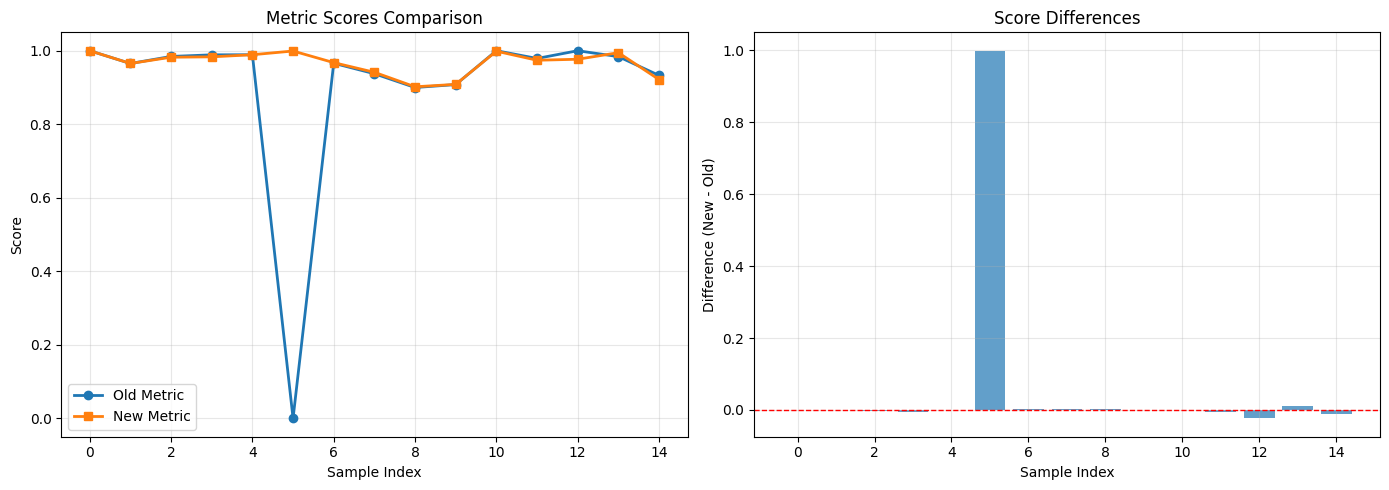

In [32]:
# Visualize the differences
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Score comparison
x = range(len(result.old_scores))
axes[0].plot(x, result.old_scores, "o-", label="Old Metric", linewidth=2)
axes[0].plot(x, result.new_scores, "s-", label="New Metric", linewidth=2)
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Score")
axes[0].set_title("Metric Scores Comparison")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Difference distribution
axes[1].bar(x, result.diffs, alpha=0.7)
axes[1].axhline(y=0, color="r", linestyle="--", linewidth=1)
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Difference (New - Old)")
axes[1].set_title("Score Differences")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Example 2: Compare Same Metric with Different LLMs

Compare how the same metric performs with different LLM models.

In [17]:
# Create two instances with different LLMs using shared utilities
llm_gpt4_mini = create_modern_llm(provider="openai", model="gpt-4o-mini")
llm_gpt4 = create_modern_llm(provider="openai", model="gpt-4o")

embeddings = create_modern_embeddings(provider="openai", model="text-embedding-ada-002")

metric_gpt4_mini = NewAnswerRelevancy(
    llm=llm_gpt4_mini, embeddings=embeddings, strictness=3
)

metric_gpt4 = NewAnswerRelevancy(llm=llm_gpt4, embeddings=embeddings, strictness=3)

In [ ]:
# Compare LLMs
result_llm = await compare_metrics(
    old_metric=metric_gpt4_mini,
    new_metric=metric_gpt4,
    dataset=test_dataset,
    old_metric_type="new",
    new_metric_type="new",
)

result_llm.print_summary()

Running old metric on 15 samples...
Running new metric on 15 samples...


## Example 3: Compare with Different Datasets

Load different datasets to test metric consistency.

In [ ]:
# Use different subsets of amnesty dataset
# First 2 samples
dataset_subset_1 = test_dataset[:2]

# Next 2 samples (if available)
dataset_subset_2 = test_dataset[2:4] if len(test_dataset) >= 4 else test_dataset[:2]

print(f"Subset 1: {len(dataset_subset_1)} samples")
print(f"Subset 2: {len(dataset_subset_2)} samples")

In [ ]:
# Compare same metric on different dataset subsets
print("\n=== Dataset Subset 1 ===")
scores_subset_1, time_subset_1 = await run_metric_on_dataset(
    new_metric, dataset_subset_1, "new"
)
print(f"Mean score: {np.mean(scores_subset_1):.4f}")
print(f"Execution time: {time_subset_1:.2f}s")

print("\n=== Dataset Subset 2 ===")
scores_subset_2, time_subset_2 = await run_metric_on_dataset(
    new_metric, dataset_subset_2, "new"
)
print(f"Mean score: {np.mean(scores_subset_2):.4f}")
print(f"Execution time: {time_subset_2:.2f}s")

## Utility: Export Results to CSV

In [ ]:
def export_comparison_results(
    result: MetricDiffResult,
    dataset: List[Dict[str, Any]],
    filename: str = "metric_comparison_results.csv",
):
    """Export comparison results to CSV file."""
    df = result.to_dataframe()

    # Add dataset information
    for key in dataset[0].keys():
        df[key] = [sample[key] for sample in dataset]

    # Add summary statistics as a separate row
    summary = pd.DataFrame(
        [
            {
                "user_input": "SUMMARY",
                "old_score": result.old_mean,
                "new_score": result.new_mean,
                "diff": result.mean_diff,
                "abs_diff": np.mean([abs(d) for d in result.diffs]),
            }
        ]
    )

    df = pd.concat([df, summary], ignore_index=True)
    df.to_csv(filename, index=False)
    print(f"Results exported to {filename}")


# Example usage
export_comparison_results(result, test_dataset, "answer_relevancy_comparison.csv")